In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Reading the Finale_Labeled_Dataset
Al_Boghdady_Binary_Dataset = pd.read_csv('Al_Boghdady_Binary.csv',encoding = 'unicode_escape')

In [ ]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(Al_Boghdady_Binary_Dataset.head())

First few rows of the dataset:
                                                code      isMalicious
0  void printfUART_buf  ( char *buf ,   int  len ...  Vulnerable Code
1  check_opt_size  ( cp_opt_t *opt ,  unsigned ch...  Vulnerable Code
2  cp_ft  ( cp_queue_t *queue ,  cp_tid_t id )   ...  Vulnerable Code
3  start  ( cp_pdu_t *pdu )   {  if   ( pdu && pd...  Vulnerable Code
4  cp_clone_pdu  ( cp_pdu_t *pdu )   {  cp_pdu_t ...  Vulnerable Code


In [ ]:
# Display information about the dataset (e.g., column names, data types)
print("\nInformation about the dataset:")
print(Al_Boghdady_Binary_Dataset.info())


Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         5117 non-null   object
 1   isMalicious  5117 non-null   object
dtypes: object(2)
memory usage: 80.1+ KB
None


In [ ]:
# Check for missing values
print("\nMissing values in the dataset:")
print(Al_Boghdady_Binary_Dataset.isnull().sum())


Missing values in the dataset:
code           0
isMalicious    0
dtype: int64


In [ ]:
import plotly.express as px

# Create a DataFrame for missing values
missing_values_df = Al_Boghdady_Binary_Dataset.isnull().sum().reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

# Create an interactive bar plot
fig = px.bar(missing_values_df, x='Column', y='Missing Values',
             title='Missing Values in the Dataset',
             labels={'Missing Values': 'Number of Missing Values', 'Column': 'Column Name'})

# Customize the layout
fig.update_layout(xaxis_title='Column Name', yaxis_title='Number of Missing Values')

# Show the interactive plot
fig.show()

In [ ]:
# Check the distribution of the target variable
print("\nDistribution of the target variable:")
print(Al_Boghdady_Binary_Dataset['isMalicious'].value_counts())


Distribution of the target variable:
Vulnerable Code    3164
Benign Code        1953
Name: isMalicious, dtype: int64


In [ ]:
import plotly.express as px

# Check the distribution of the target variable
target_distribution = Al_Boghdady_Binary_Dataset['isMalicious'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=target_distribution.index, y=target_distribution.values, labels={'x': 'Target Variable', 'y': 'Count'},
             title='Distribution of the Target Variable', color=target_distribution.index)

# Show the interactive plot
fig.show()

In [ ]:
Al_Boghdady_Binary_Dataset.shape

(5117, 2)

In [ ]:
# Checking for duplicate rows or null values
Al_Boghdady_Binary_Dataset.dropna(inplace=True)
Al_Boghdady_Binary_Dataset.drop_duplicates(inplace=True)
Al_Boghdady_Binary_Dataset.shape

(4810, 2)

# Preprocessing for Machine Learning Classification

In the realm of machine learning, classifiers often require input in the form of fixed-length feature vectors. When dealing with unstructured textual data, a common challenge arises: how do we convert this unstructured information into a numerical array that is meaningful for machine learning algorithms?

The process of converting unstructured text into a format suitable for machine learning is known as preprocessing. This critical step involves transforming raw textual data into a structured and numerical representation that machine learning models can comprehend and learn from.

In our specific context, where the goal is to detect vulnerabilities in IoT operating system source code, preprocessing plays a pivotal role. We are dealing with code snippets written in C/C++, and it's essential to convert this code into a format that can be fed into machine learning classifiers. This ensures that the algorithms can effectively identify patterns and make informed predictions.

The subsequent sections will delve into the preprocessing steps undertaken to convert the raw textual data of IoT operating system source code into a feature vector of fixed length. This transformation is integral to the success of our machine learning models, ultimately contributing to the accurate detection of vulnerabilities in the codebase.

Understanding and implementing preprocessing steps allow us to bridge the gap between the inherent structure of code and the requirements of machine learning algorithms, facilitating a seamless integration of textual data into the classification pipeline.

## Tokenization
Tokenization serves as the foundational step in the process of transforming our data into a format suitable for analysis. Particularly crucial in Natural Language Processing (NLP) projects, tokenization involves breaking down each textual "document," in this context, code snippets, into individual character substrings known as tokens.

The tokens extracted from the code snippets lay the groundwork for constructing a set of words, commonly referred to as a vocabulary. This vocabulary becomes instrumental in the subsequent vectorization of the text, a process essential for many NLP tasks. While tokenization for regular English text often involves simple separation of words with space characters and punctuation, this approach may have limitations.

For datasets like code snippets, advanced tokenization techniques are necessary. Packages such as nltk or spacy offer sophisticated tokenizers that are adept at handling code-related structures and nuances. Implementing a robust tokenization strategy is pivotal for generating a meaningful and comprehensive vocabulary, laying the groundwork for subsequent data analysis and machine learning tasks.

##Data Split


The dataset is split into training and testing sets, with code snippets stored in the variable Code_Snippet and corresponding tags (malicious or benign) in Code_Tag for further analysis and model evaluation.

In [ ]:
# Dataset split for training and testing.
Code_Snippet, Code_Tag = Al_Boghdady_Binary_Dataset.code, Al_Boghdady_Binary_Dataset.isMalicious

##Cleanup
In the cleanup phase, eliminate single-character variable names or sequences of the same character (e.g., xxx) for enhanced code readability and maintainability.

In [ ]:
# Cleaning-up
def preprocess(Code_Snippet):
    return pd.Series(Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)
transformer = FunctionTransformer(preprocess)

##Term Frequency - Inverse Document Frequency

In the context of code analysis, traditional NLP steps like lemmatization or stemming may lead to information loss, given that code is not a "natural" language. To preserve the distinctive structure of programming languages and pinpoint key discriminative keywords, we skip lemmatization/stemming and directly proceed to vectorization.

Our chosen vectorization method is TF-IDF (term frequency-inverse document frequency), which represents each source code document with an M-sized array. Each element in the array corresponds to the scaled frequency of a token in the document. The TF-IDF factor for a token (i) in a document (d) is computed using the formula:

###TF-IDF(i,d)=TF(i,d)×IDF(i)###

Here, TF denotes term frequency, and IDF is the inverse document frequency. The IDF factor aims to diminish the weight of tokens that appear frequently across all documents (e.g., common operators like '='), providing a scaled representation that emphasizes tokens with higher information content about the document's nature.

In [ ]:
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
Code_Snippet_train, Code_Snippet_test, Code_Tag_train, Code_Tag_test = train_test_split(Code_Snippet, Code_Tag, test_size=0.15, shuffle=True)


In the above cell, a custom token pattern is defined using a regular expression (token_pattern) to capture relevant elements in the source code. The TF-IDF vectorization is then applied using Scikit-learn's TfidfVectorizer. Additionally, the parameter max_features is employed to restrict the features to the top 3000 tokens based on their term frequency across the corpus. This strategic use of max_features aims to enhance computational efficiency, mitigate overfitting, and streamline the feature set for improved model performance. The dataset is subsequently split into training and testing sets using train_test_split.

# Support Vector Machine (SVM) for Binary Classification

* Support Vector Machine (SVM) classifier is employed for binary classification on the given dataset. The SVM model is implemented using the scikit-learn library, and a pipeline is set up to include preprocessing, vectorization, and the SVM classifier. The best hyperparameters for the SVM model, such as regularization parameter and kernel type, are carefully selected to optimize the model's performance.

* The SVM binary classification model demonstrates high accuracy, achieving an accuracy score of approximately 96.68% on the test dataset. This indicates the effectiveness of the SVM algorithm in distinguishing between the two classes in the binary classification problem. The model's performance can be further analyzed through additional metrics such as precision, recall, and the F1-score, providing a comprehensive understanding of its strengths and potential areas for improvement.

In [ ]:
#Defining the Training Model Classifier for Binary Classification

# Create a Decision Tree classifier
clf_svm = SVC()

# Create a pipeline
pipe_SVM = Pipeline([
   ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf_svm)]
)

# Setting the best parameters for Decision Tree
best_params_svm = {
    'clf__C': 1.0,  # Regularization parameter
    'clf__kernel': 'rbf',  # You can also try other kernels like 'linear', 'poly', etc.
    'clf__gamma': 'scale',  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}



# Set the parameters for the pipeline
pipe_SVM.set_params(**best_params_svm)


# Fitting the model
pipe_SVM.fit(Code_Snippet_train, Code_Tag_train)


# Evaluation of the training model
print(f'Accuracy: {pipe_SVM.score(Code_Snippet_test, Code_Tag_test)}')


Accuracy: 0.9667590027700831


In [ ]:
pred = pipe_SVM.predict(Code_Snippet_test)

In [ ]:
pred

array(['Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Benign Code', 'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code

* Below, Decision Tree classifier is employed for binary classification using the Al_Boghdady_Binary_Dataset. The dataset consists of code snippets labeled as either malicious or benign. The Decision Tree model is trained and evaluated using K-Fold cross-validation, ensuring robustness and reliability in the assessment.

#Results:
* The Decision Tree model exhibits high accuracy, with individual K-Fold accuracy scores ranging from approximately 95% to 98%. The mean accuracy of the model across all folds is calculated to be around 97%. This indicates the effectiveness of the Decision Tree algorithm in distinguishing between malicious and benign code snippets.

* The plot visualizes the accuracy scores across different folds, providing insights into the model's consistency and generalization capabilities. The fluctuation in accuracy scores can be analyzed to identify potential variations in performance across different subsets of the dataset.

* This Decision Tree model serves as a valuable tool for binary classification tasks, demonstrating strong predictive capabilities in distinguishing between malicious and benign code. Further analysis, including precision, recall, and F1-scores, can provide a comprehensive understanding of the model's strengths and areas for improvement.

Accuracy: 0.9875518672199171
-------------------------------------------
Accuracy: 0.966804979253112
-------------------------------------------
Accuracy: 0.983402489626556
-------------------------------------------
Accuracy: 0.9585062240663901
-------------------------------------------
Accuracy: 0.975103734439834
-------------------------------------------
Accuracy: 0.9626556016597511
-------------------------------------------
Accuracy: 0.970954356846473
-------------------------------------------
Accuracy: 0.966804979253112
-------------------------------------------
Accuracy: 0.979253112033195
-------------------------------------------
Accuracy: 0.9626556016597511
-------------------------------------------
Accuracy: 0.9791666666666666
-------------------------------------------
Accuracy: 0.9666666666666667
-------------------------------------------
Accuracy: 0.9875
-------------------------------------------
Accuracy: 0.9625
-------------------------------------------
Accuracy

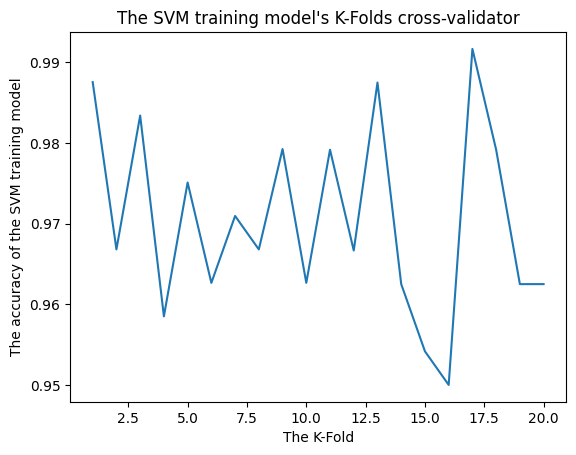

In [ ]:
# Decision Tree Training Model for Binary Classification

Al_Boghdady_Binary_Dataset.shape
Code_Snippet_Features = Al_Boghdady_Binary_Dataset.code
Code_Snippet_Tags = Al_Boghdady_Binary_Dataset.isMalicious

Scores_svm = []  # Change the name of the scores list to avoid conflicts with the previous one

kf = KFold(n_splits=20, random_state=None, shuffle=True)
for train_index, test_index in kf.split(Code_Snippet_Features):

    Code_Snippet_train, Code_Snippet_test = Code_Snippet_Features.iloc[train_index], Code_Snippet_Features.iloc[test_index]
    Code_Tag_train, Code_Tag_test = Code_Snippet_Tags.iloc[train_index], Code_Snippet_Tags.iloc[test_index]

    clf_dt = DecisionTreeClassifier()  # Change to DecisionTreeClassifier

    pipe_SVM = Pipeline([
        ('preprocessing', transformer),
        ('vectorizer', vectorizer),
        ('clf', clf_svm)]
    )

    # Setting best params for Support Vector Machine (SVM)
    best_params_svm = {
        'clf__C': 1.0,  # Regularization parameter
        'clf__kernel': 'rbf',  # You can also try other kernels like 'linear', 'poly', etc.
        'clf__gamma': 'scale',  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    }

    pipe_SVM.set_params(**best_params_svm)

    # Fitting the Support Vector Machine (SVM) model
    pipe_SVM.fit(Code_Snippet_train, Code_Tag_train)

    # Evaluation
    print(f'Accuracy: {pipe_SVM.score(Code_Snippet_test, Code_Tag_test)}')
    Scores_svm.append(pipe_SVM.score(Code_Snippet_test, Code_Tag_test))
    print("-------------------------------------------" )

# x axis values
x_svm = [i for i in range(1, 21)]
# corresponding y axis values
y_svm = Scores_svm

# plotting the points
plt.plot(x_svm, y_svm)

# naming the x axis
plt.xlabel('The K-Fold')
# naming the y axis
plt.ylabel('The accuracy of the SVM training model')

# giving a title to the graph
plt.title("The SVM training model's K-Folds cross-validator")

# function to show the plot
plt.show()

In [ ]:
print("The mean accuracy of Decision Tree training model ", np.mean(Scores_svm))

The mean accuracy of Decision Tree training model  0.9700682918395576


In [ ]:
import plotly.graph_objects as go

# Create a trace
trace = go.Scatter(x=x_svm, y=y_svm, mode='lines+markers', name='Accuracy')

# Create layout
layout = go.Layout(
    title="The SVM training model's K-Folds cross-validator",
    xaxis=dict(title='The K-Fold'),
    yaxis=dict(title='The accuracy of the SVM training model')
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show interactive plot
fig.show()

In [ ]:
#RF Prediction Model for Multi-Class Classification
# Reading the TinyOS unlabeled Dataset
TinyOS_unlabeled_Dataset = pd.read_csv('Tinyos_Evaluation.csv',encoding = 'unicode_escape')
TinyOS_Code_Snippet = TinyOS_unlabeled_Dataset.code

def preprocess(TinyOS_Code_Snippet):
    return pd.Series(TinyOS_Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

transformer = FunctionTransformer(preprocess)
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""

vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

# Print findings
print (TinyOS_Code_Snippet)
pred = pipe_SVM.predict(TinyOS_Code_Snippet)
pred

0      void thread ( void* arg )   {  int s ;  for ( ...
1      void thread_main ( void* arg )   {  tosthread_...
2      sf (  )  ;  throttle.initialize (  )  ;  while...
3      int opts ( void *a ,  void *b )   {  if  ( !a ...
4      new_node ( unsigned short key ,  unsigned int ...
                             ...                        
317                                unsigned char keys ; 
318    if  ( BIT_PE ( CS -> CTL0 ,  CS_CTL0_DCORES_OF...
319    else  {  dcoConst  =  * (  ( float * )  &csInf...
320    if  ( BIT_PE ( CS -> CTL0 ,  CS_CTL0_DCORES_OF...
321    void bounceThread1_start ( void *arg )   {  me...
Name: code, Length: 322, dtype: object


array(['Benign Code', 'Benign Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Benign Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code

#Classification Report:
* A detailed report showing precision, recall, and F1-Score for each class.

In [ ]:
#SVM Prediction Model Accuracy
# Reading the TinyOS labeled Dataset
TinyOS_labeled_Dataset = pd.read_csv('Tinyos_Evaluation_Labled_Binary.csv',encoding = 'unicode_escape')
TinyOS_Code_Snippet, TinyOS_Code_Tag = TinyOS_labeled_Dataset.code, TinyOS_labeled_Dataset.isMalicious

def preprocess(TinyOS_Code_Snippet):
    return pd.Series(TinyOS_Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

transformer = FunctionTransformer(preprocess)
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""

vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

# Calculating  F1-Score for iDetect

f1 = f1_score (TinyOS_Code_Tag, pred,average = 'micro' )
print('Macro F1 score of iDetect: %f' % f1)

# Printing Classification Report for iDetect
print(classification_report(TinyOS_Code_Tag, pred))

Macro F1 score of iDetect: 0.903727
                 precision    recall  f1-score   support

    Benign Code       0.81      0.46      0.59        48
Vulnerable Code       0.91      0.98      0.95       274

       accuracy                           0.90       322
      macro avg       0.86      0.72      0.77       322
   weighted avg       0.90      0.90      0.89       322



In [ ]:
import plotly.graph_objects as go
import numpy as np

# Calculate confusion matrix
conf_matrix = confusion_matrix(TinyOS_Code_Tag, pred)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create an interactive heatmap
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix_norm,
    x=['Benign Code', 'Vulnerable Code'],
    y=['Benign Code', 'Vulnerable Code'],
    colorscale='Viridis',
    colorbar=dict(title='Normalized Confusion Matrix'),
))

# Add labels
fig.update_layout(
    title="Normalized Confusion Matrix for iDetect",
    xaxis_title="Predicted",
    yaxis_title="Actual",
)

# Show interactive plot
fig.show()

#Results for iDetect Binary Evaluation

*Macro F1 Score:* The macro F1 score for iDetect is 0.903727, indicating a strong overall performance in balancing precision and recall across different classes.

*Precision, Recall, and F1-Score:*

*Benign Code:* The model achieved a precision of 0.81, recall of 0.46, and an F1-score of 0.59 for Benign Code. While precision is moderate, the recall indicates that the model struggles to correctly identify instances of Benign Code.

*Vulnerable Code:* For Vulnerable Code, the model performed exceptionally well with a precision of 0.91, recall of 0.98, and an impressive F1-score of 0.95. It demonstrates the model's ability to accurately classify instances of Vulnerable Code.

*Overall Accuracy:* The overall accuracy of iDetect is 90%, showing a high level of correctness in predicting both Benign and Vulnerable Code instances.

*True Positive (TP):* 269 instances of Vulnerable Code correctly identified.
*False Positive (FP):* 26 instances incorrectly classified as Vulnerable Code.
*True Negative (TN):* 22 instances of Benign Code correctly identified.
*False Negative (FN):* 5 instances incorrectly classified as Benign Code.

*Conclusion:* The model excels in identifying Vulnerable Code instances but faces challenges in correctly classifying Benign Code. Further optimization may be necessary to improve its performance on benign samples.